# 125. Malware Detection - binary classification

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
df = pd.read_csv('sample_data/malware.csv', index_col=0)
df.head()

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
65416,VirusShare_3ede9b62781398a2e39a0f6af9356a54,3ede9b62781398a2e39a0f6af9356a54,332,224,258,10,0,117760,392192,0,...,5,3.425849,2.458492,4.035538,3146.400000,48,9640,72,15,0
23220,fxsocm.dll,9a0959a682d8eba06d0bd181c49ee2a8,332,224,8462,7,10,112640,29696,0,...,8,3.911994,2.669737,5.335373,1222.750000,164,4889,72,16,1
118017,VirusShare_abe7101746242c922a539ba461db4e38,abe7101746242c922a539ba461db4e38,332,224,258,10,0,119808,385024,0,...,6,3.776760,2.458492,5.317552,2740.166667,48,9640,72,15,0
69842,VirusShare_64a1247fc96d5bc2994ef89ca09adee8,64a1247fc96d5bc2994ef89ca09adee8,332,224,258,10,0,120320,385024,0,...,6,3.756068,2.458492,5.317552,2739.500000,48,9640,72,15,0
22165,asferror.dll,ebc23440aa9cc4f08241d35147c1d5b5,332,224,8462,7,10,0,7168,0,...,2,3.488703,3.471506,3.505901,3050.000000,888,5212,0,16,1


In [4]:
df.shape

(10000, 57)

In [5]:
df['legitimate'].value_counts()

0    7071
1    2929
Name: legitimate, dtype: int64

In [6]:
df.columns

Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',
       'Impor

- Name : 제외
- md5 : hash value 제외

In [7]:
df = df.iloc[:, 2:]

df.shape

(10000, 55)

In [8]:
y = df.pop('legitimate').values
X = df.values

- Train, Test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 54), (2000, 54), (8000,), (2000,))

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [11]:
X_train_ts = torch.FloatTensor(X_train)
X_test_ts = torch.FloatTensor(X_test)
y_train_ts = torch.FloatTensor(y_train).view(-1, 1)
y_test_ts = torch.FloatTensor(y_test).view(-1, 1)

## ``nn.Module``을 이용한 사용자 정의 Logistic Regression model 정의 

In [12]:
class LogisticReg(nn.Module):
    def __init__(self, in_dim):
        super(LogisticReg, self).__init__()
        self.linear1 = nn.Linear(in_dim, 32)
        self.linear2 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        out = torch.sigmoid(self.linear2(x))
        return out

In [13]:
model = LogisticReg(X_train.shape[1]).to(device)

# random 하게 초기화 된 parameter 출력
print(model)

LogisticReg(
  (linear1): Linear(in_features=54, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)


In [14]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### dataset loader 생성

In [15]:
train_ds = torch.utils.data.TensorDataset(X_train_ts, y_train_ts)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)

# 생성한 Neural Network Model Train

In [16]:
Loss = []
num_epochs = 50

for epoch in range(num_epochs):
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        yhat = model(x)
        loss = criterion(yhat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))
    Loss.append(loss.item())

epoch 1 loss: 0.6139
epoch 2 loss: 0.5180
epoch 3 loss: 0.4085
epoch 4 loss: 0.2970
epoch 5 loss: 0.2199
epoch 6 loss: 0.1788
epoch 7 loss: 0.1478
epoch 8 loss: 0.1103
epoch 9 loss: 0.0945
epoch 10 loss: 0.0991
epoch 11 loss: 0.0642
epoch 12 loss: 0.0716
epoch 13 loss: 0.0783
epoch 14 loss: 0.0602
epoch 15 loss: 0.0805
epoch 16 loss: 0.1063
epoch 17 loss: 0.0633
epoch 18 loss: 0.0395
epoch 19 loss: 0.0747
epoch 20 loss: 0.0675
epoch 21 loss: 0.0535
epoch 22 loss: 0.0389
epoch 23 loss: 0.0590
epoch 24 loss: 0.0528
epoch 25 loss: 0.0556
epoch 26 loss: 0.0365
epoch 27 loss: 0.0511
epoch 28 loss: 0.0527
epoch 29 loss: 0.0415
epoch 30 loss: 0.0677
epoch 31 loss: 0.0322
epoch 32 loss: 0.0463
epoch 33 loss: 0.0626
epoch 34 loss: 0.0642
epoch 35 loss: 0.0556
epoch 36 loss: 0.0452
epoch 37 loss: 0.0326
epoch 38 loss: 0.0309
epoch 39 loss: 0.0616
epoch 40 loss: 0.0446
epoch 41 loss: 0.0216
epoch 42 loss: 0.0526
epoch 43 loss: 0.0336
epoch 44 loss: 0.0482
epoch 45 loss: 0.0239
epoch 46 loss: 0.03

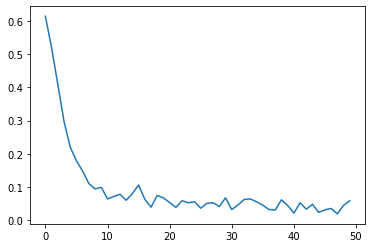

In [17]:
plt.plot(Loss)

In [18]:
y_pred = model(X_test_ts.to(device)).cpu().detach().numpy() > 0.5

In [19]:
sum(y_test == y_pred.flatten()) / len(y_test)

0.9865